# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.062806,False,0.159980
1,-0.897001,False,-0.968306
2,-1.313631,False,-0.279971
3,-0.317817,False,0.502713
4,-2.335533,False,-1.023609
...,...,...,...
995,-0.248615,False,-1.725051
996,-0.436043,False,-0.586123
997,-1.477794,False,-1.815060
998,-2.007911,False,-0.962901


<AxesSubplot: xlabel='v0'>

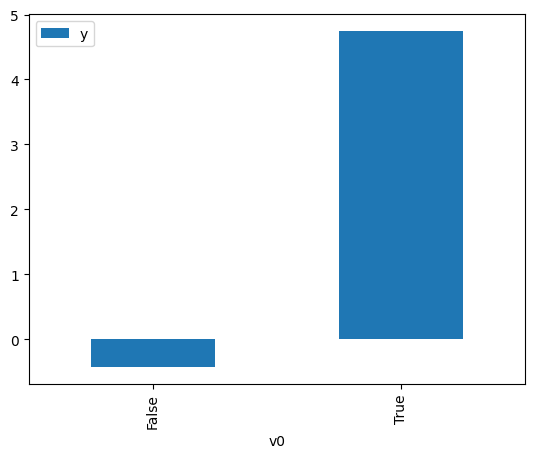

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

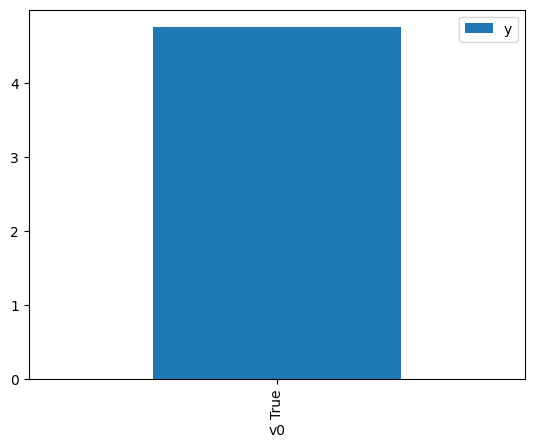

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.058435,False,0.195888,0.403531,2.478127
1,0.280076,False,-0.708436,0.287687,3.475998
2,-0.035630,False,0.296982,0.457145,2.187489
3,-2.126480,False,-0.731496,0.990938,1.009145
4,0.656995,False,0.782559,0.143820,6.953155
...,...,...,...,...,...
995,-2.079757,False,-1.523027,0.989908,1.010195
996,-0.012703,False,0.365681,0.443936,2.252577
997,-0.353660,False,-0.249205,0.638387,1.566448
998,-0.217553,False,-2.039930,0.562566,1.777569


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.765091,True,4.315843,0.178583,5.599623
1,2.976666,True,5.991654,0.999241,1.000759
2,-0.068332,True,6.238496,0.523913,1.908712
3,1.074347,True,5.968406,0.940212,1.063590
4,0.063721,True,4.219795,0.599428,1.668258
...,...,...,...,...,...
995,-0.839661,True,2.823131,0.154526,6.471404
996,-0.274924,True,6.450790,0.404894,2.469780
997,-1.179147,True,4.665587,0.076584,13.057493
998,-0.727631,True,6.956859,0.191733,5.215575


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.919
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              5629.
Date:                Mon, 14 Nov 2022   Prob (F-statistic):                        0.00
Time:                        15:14:25   Log-Likelihood:                         -1418.0
No. Observations:                1000   AIC:                                      2840.
Df Residuals:                     998   BIC:                                      2850.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6300      0.029     22.060      0.000       0.574       0.686
x2             5.0743      0.052     97.549      0.000       4.972       5.176
==============================================================================
Omnibus:                        2.531   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                2.232
Skew:                          -0.006   Prob(JB):                        0.328
Kurtosis:                       2.769   Cond. No.                         1.89
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""